In [62]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
import ast
from gensim.models import Word2Vec,KeyedVectors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe181848a90>]],
      dtype=object)

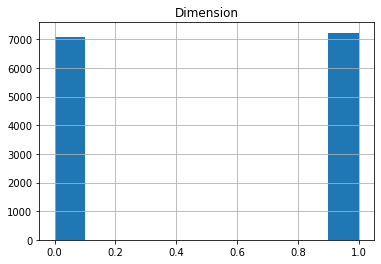

In [63]:
#df = pd.read_csv("../Data/Flujo1.csv", sep=";")
df = pd.read_csv('drive/My Drive/Tesis/Data/Flujo1.csv', sep=";")
df = df[df.Area == 'Gobierno Corporativo']
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)
list_raw_dimensions = df.Dimension.unique().tolist()
def enumerate_dimensions(dimension):
    return list_raw_dimensions.index(dimension)

df['Dimension'] = df.Dimension.apply(enumerate_dimensions)
model = Word2Vec.load('drive/My Drive/Tesis/modelWord2vec.bin')
list_responses = list(df.Respuesta)
list_dimensions = list(df.Dimension)
df.hist('Dimension')

In [0]:
def make_feature_vec(words, model, num_features):
    feature_vec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,model[word])
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

def get_avg_feature_vecs(reviews, model, num_features):
    counter = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1
    return review_feature_vecs

In [16]:
num_features = 10
list_responses_vec = get_avg_feature_vecs(list_responses, model, num_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [0]:
x_train, x_test, y_train, y_test = train_test_split(list_responses_vec, list_dimensions, test_size = 0.2, random_state = 0)

In [69]:
forest = ''
forest = RandomForestClassifier(n_jobs=3, oob_score = True, max_depth=9, n_estimators=1000, bootstrap = True)
acc = cross_val_score(forest, list_responses_vec, list_dimensions, scoring='accuracy', cv=10)
print(acc.mean())

0.6849765060121953


In [57]:
forest.fit(x_train , y_train)
predicctions = forest.predict(x_test)
score = accuracy_score(y_test ,predicctions)
print("Predicting labels for test data..")
print(classification_report(y_test, predicctions))

Predicting labels for test data..
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1434
           1       0.71      0.67      0.69      1426

    accuracy                           0.70      2860
   macro avg       0.70      0.70      0.70      2860
weighted avg       0.70      0.70      0.70      2860



In [68]:
confusion_matrix(y_test, predicctions)

array([[1051,  383],
       [ 474,  952]])

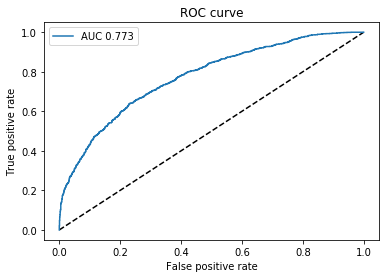

In [60]:
probs = forest.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()